Importing all necessary packages

In [2]:
# cell 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.under_sampling import TomekLinks

Loading dataset (this is a csv file)

In [3]:
# cell 2
data = pd.read_csv("churn.csv")

Examining dataset structure :

Randomly choose 10 sample of them (total 10,000)

In [4]:
# cell 3
data.sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6915,6916,15751549,H?,658,Germany,Male,31,2,77082.65,2,0,0,13482.28,0
8762,8763,15765173,Lin,350,France,Female,60,3,0.00,1,0,0,113796.15,1
4341,4342,15665376,Lavrentiev,647,Germany,Female,35,3,166518.63,2,1,0,147930.46,0
527,528,15573318,Kung,610,France,Male,26,8,0.00,2,1,0,166031.08,0
5788,5789,15694566,Roberts,602,France,Female,42,10,0.00,2,0,0,169921.11,1
170,171,15587562,Hawkins,484,France,Female,29,4,130114.39,1,1,0,164017.89,0
834,835,15780628,Wu,633,France,Female,30,6,0.00,2,0,0,41642.29,0
3810,3811,15746802,Onio,477,France,Female,30,6,131286.46,1,1,0,194144.45,0
2045,2046,15655238,Dellucci,668,France,Female,31,9,0.00,2,0,0,41291.73,0
6513,6514,15609254,Fernandez,513,Spain,Female,41,9,107135.04,2,1,1,160546.58,0


getting some statistical intuition from our dataset

In [5]:
# cell 4
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Check if there are any missing values (NaN) ​​in the dataset.

In [6]:
# cell 5
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

result : there is no any NaN in dataset

Is there any duplicated sample in our dataset?

In [7]:
# cell 6
data.duplicated().sum()

np.int64(0)

result : also, there is no any duplicated sample in dataset

As we know, the 'RowNumber', 'CustomerId' and 'Surname' have no effect on leaving the bank or not.

Therefore, we can ignore them :

In [8]:
# cell 7
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

Now we want to check the relationship between other features with 'Exited' (whether he/she leaves the bank or not) of each sample.

How many of the total customers have left the bank during the last month?

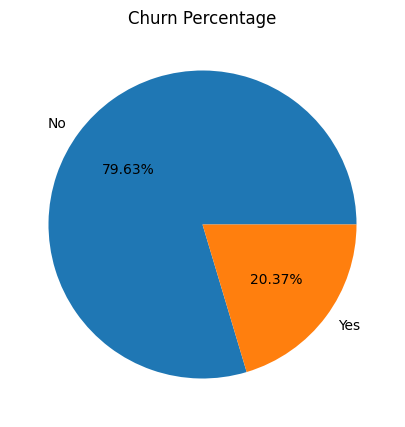

In [9]:
# cell 8
plt.figure(figsize=(15,5))
plt.pie(data['Exited'].value_counts(), labels=['No', 'Yes'], autopct='%1.2f%%')
plt.title('Churn Percentage')
plt.show()

Result : This chart indicates that only 20.4% of all our customers have blocked their accounts in the last month.

How many men and women are no longer bank customers?

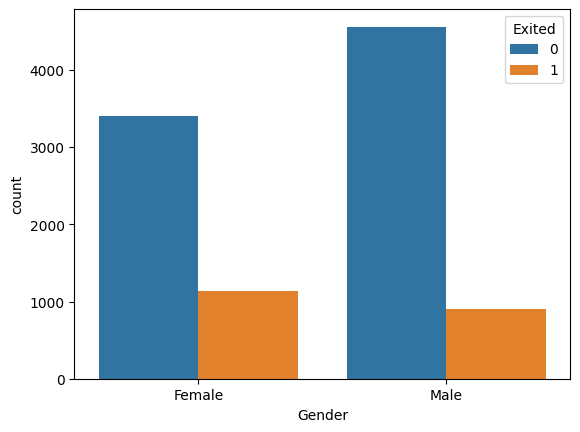

In [10]:
# cell 9
sns.countplot(x = 'Gender', data=data, hue='Exited')
plt.show()

Result : Most of our customers are men. but more women have left the bank. but this difference isn't so obvious.

Now let's check in which age range most of our customers are and whether there is more customer churn in a certain age range or not.

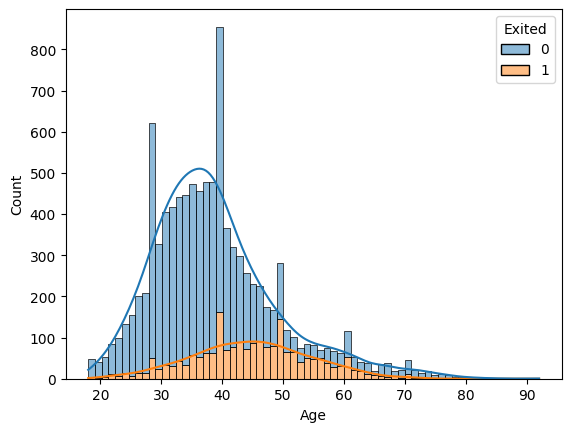

In [11]:
# cell 10
sns.histplot(data=data, x='Age', hue='Exited',multiple='stack', kde=True)
plt.show()

Result : As you see, most of our customers are young people between 30 and 40 years old. But most of the churn that the bank has faced have been in the age range of 40 to 50 years.

What effect does each person's credit score have on their leaving the bank?

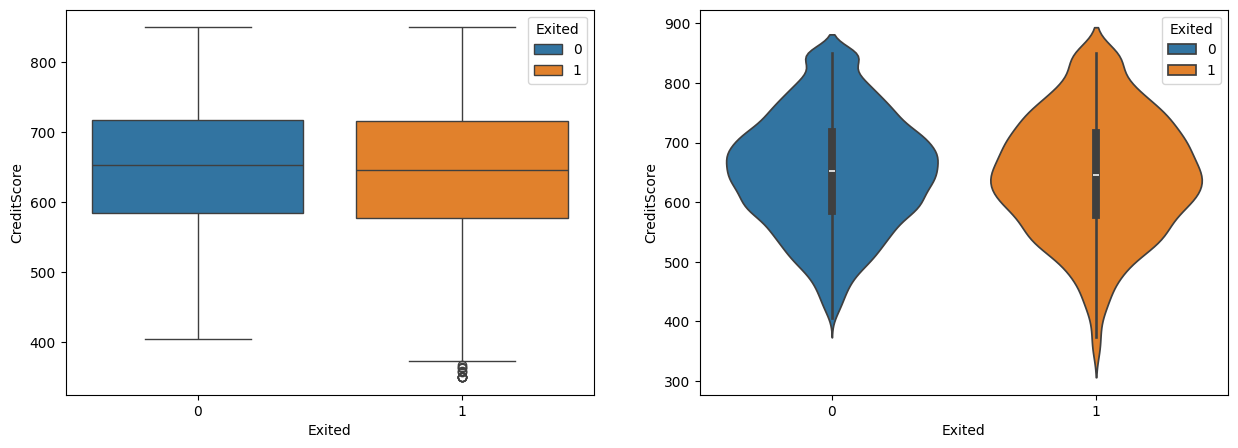

In [12]:
# cell 11
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x='Exited', y='CreditScore', data=data, ax=ax[0], hue='Exited')
sns.violinplot(x='Exited', y='CreditScore', data=data, ax=ax[1], hue='Exited')
plt.show()

Result : Regarding the box plot, we can say that both the exited and non-exited groups have the same distribution around their credit scores.
The same is true for the violin plot. With a slight difference, it can be said that those who leave the bank have obtained a lower credit score.
But the final point of view: credit score has no effect on the churn of customers.

From which countries do we have customers and which country do most of our churn belong to?

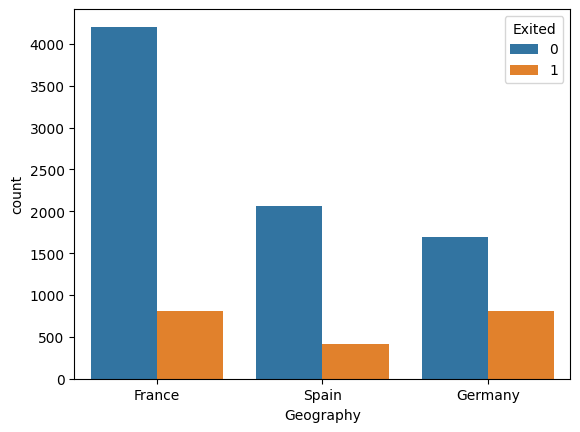

In [13]:
# cell 12
sns.countplot(x='Geography', hue='Exited', data=data)
plt.show()

Result : As you can see, most of our customers are dear French people, but in terms of churn, it can be said that Germans had the highest churn compared to their population in the bank. Two issues can be discussed : 

1- Why are our German customers so few? (We are not in a position to investigate this issue)

2- why are German customers leaving our bank? Are they unhappy with our services or is there another reason?

Tenure refers to the time (in years) that a customer has been a client of the bank. It is better to check the loyalty of bank customers. (:

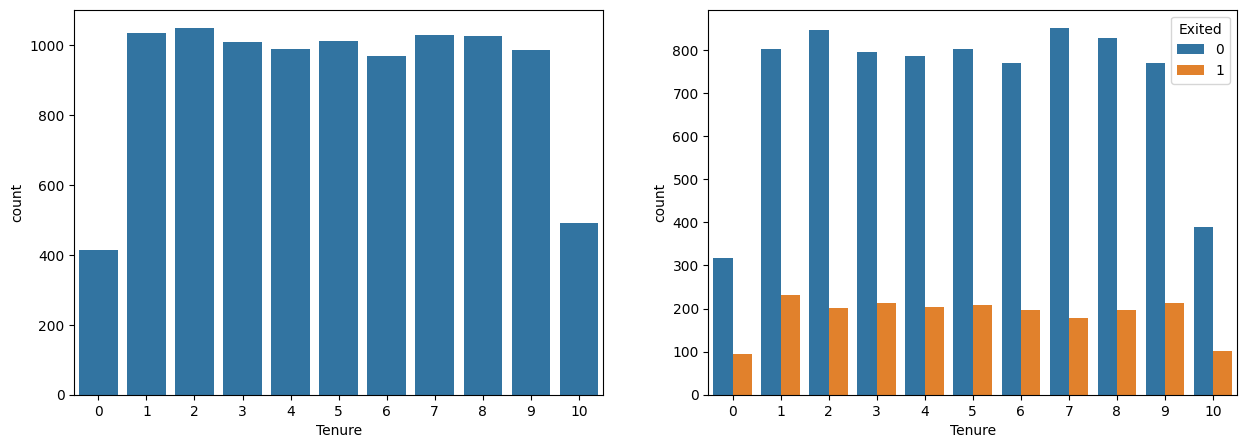

In [14]:
# cell 13
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x='Tenure', data=data, ax=ax[0])
sns.countplot(x='Tenure', data=data, ax=ax[1], hue='Exited')
plt.show()

Result : Most of the customers have been with the bank for between 1 to 9 years. Now, these same customers have the largest drop among other customers. The reason for this should be investigated.

Bank Balance :

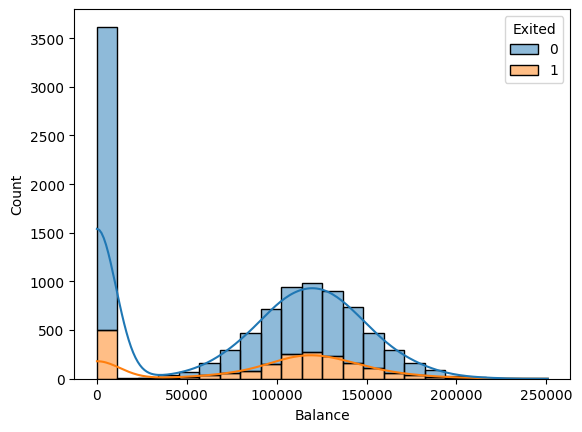

In [15]:
# cell 14
sns.histplot(data=data, x='Balance', hue='Exited', multiple='stack', kde=True)
plt.show()

Result : A huge number of customers have zero bank balance which resulted in them leaving the bank. Also, customers with bank balances between 100,000 and 150,000 have seen the biggest churn in the past month.

We assume that the number of products that the bank provides to customers has a opposite effect on the churn of customers:

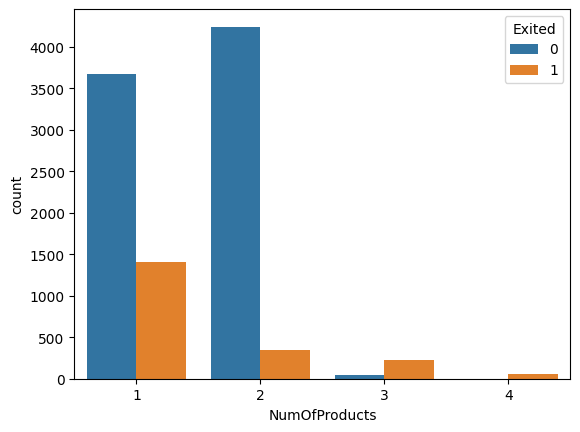

In [16]:
# cell 15
sns.countplot(x='NumOfProducts', hue='Exited', data=data)
plt.show()

Result : The bank offers customers 1, 2, 3 or 4 products, and as we guessed, the churn is much lower for customers who received more products than for customers who received fewer products. 

HasCreditCard :

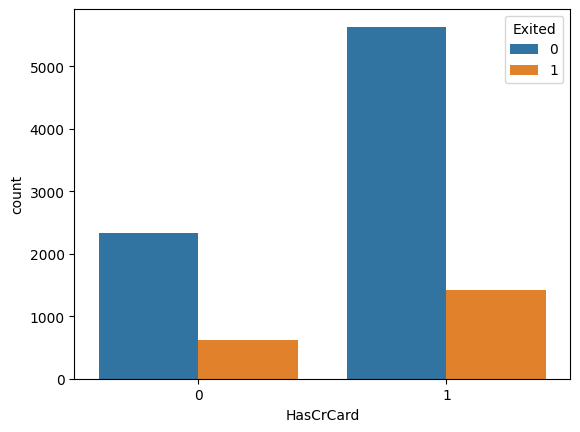

In [17]:
# cell 16
sns.countplot(x='HasCrCard', data=data, hue='Exited')
plt.show()

Result : most of the customers have credit card. Also, people who have a credit card had more exit from the bank.

IsActiveMember :

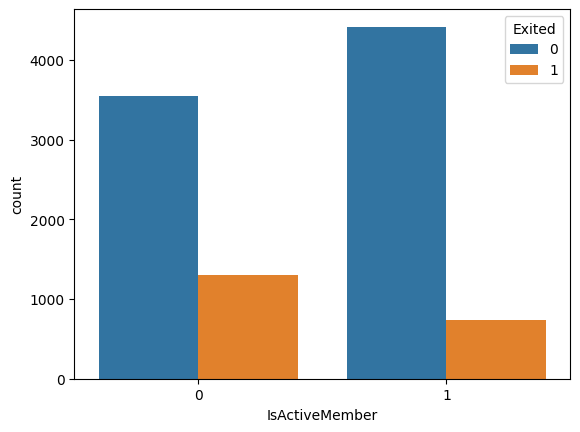

In [18]:
# cell 17
sns.countplot(x='IsActiveMember', hue='Exited', data=data)
plt.show()

Result : most of the customers are active. but a huge valume of churn belogs to inactive members.

How Estimated Salary effect on churn?

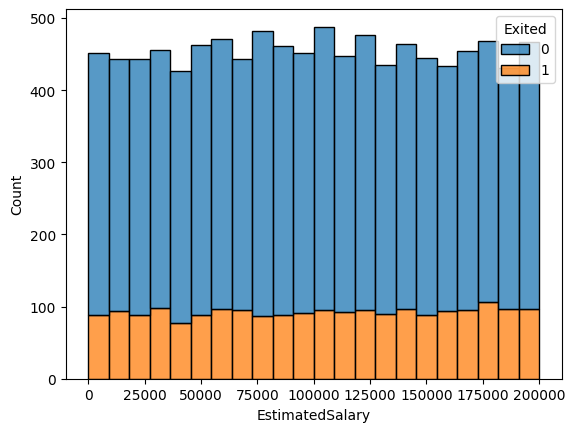

In [19]:
# cell 18
sns.histplot(data=data, x='EstimatedSalary', hue='Exited', multiple='stack')
plt.show()

Result : As we estimated, the amount of salary received by our clients is a wide range from 0$ to 200,000$ And as it is evident, the amount of salary received or income has no effect on the churn of customers.

In order to feed the dataset to the model, we first need to make sure that the feature values ​​are all numeric.
In other words, if we had bool or string data, we have to convert them into numeric values ​​using one of the following two methods :

1- Label Encoding : according to a specific feature, give's a unique number to each category.

2- OneHot Encoding : according to a specific feature, create a new column for each category of the feature.

Making sure we don't have any categorical feature : 

In [20]:
# cell 19
data.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Result : As you can see, 'Geography' and 'Gender' are categorical features and we have to convert to numerical.

We prefered to use "OneHot Encoding" beacause thoes categories don't have order. for example, there isn't any order between 'Germany', 'France' and 'Spain' : 

In [21]:
# cell 20
data = pd.get_dummies(data, dtype=np.int64)

In [22]:
# cell 21
data.shape

(10000, 14)

Checking is our data imbalanced or not...

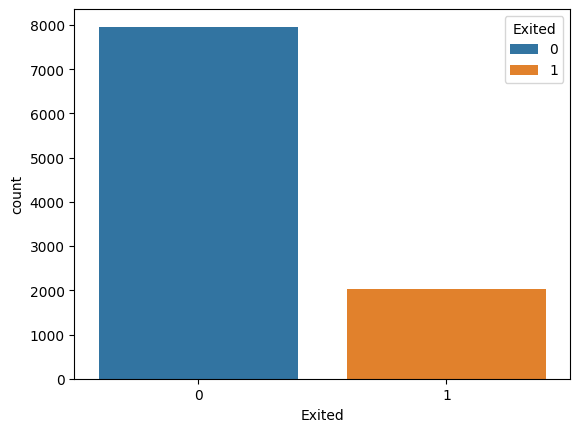

In [23]:
# cell 22
sns.countplot(data=data, x='Exited', hue='Exited')
plt.show()

Result : As you see number of loyal customers are four times bigger that churned ones. So, we have to balance target classes. To avide data lekage, we will do it after spliting data into train and test.

By Scaling our data, the performance of the model is improved :

In [24]:
# cell 23
columns = ['CreditScore', 'Balance', 'EstimatedSalary']
robust_scaler = RobustScaler().fit(data[['CreditScore', 'Balance', 'EstimatedSalary']])
data[['CreditScore', 'Balance', 'EstimatedSalary']] = pd.DataFrame(robust_scaler.transform(data[['CreditScore', 'Balance', 'EstimatedSalary']]), columns=columns)

##### Split data into Train and Test

In [25]:
# cell 24
X = data.drop(['Exited'], axis=1)
y = data['Exited']

In [26]:
# cell 25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)

We have to balance target classes using undersampling here :

In [27]:
# cell 26
tomek = TomekLinks()
X_train, y_train = tomek.fit_resample(X_train, y_train)

Decision Tree : 

Note: We will use 'GridSearchCV' to find best hyperparameters of 'DecisionTreeClassifier' and 'RandomForestClassifier'.

In [28]:
# cell 27
dtree = DecisionTreeClassifier()

param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2,4,6,8,10,12,14,16,18,20], 
              'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10],
              'random_state': [0, 42]}

grid_dtree = GridSearchCV(dtree, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_dtree.fit(X_train, y_train)

print(grid_dtree.best_params_)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10, 'random_state': 0}


In [29]:
# cell 28
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=6, min_samples_leaf=10, random_state=0)

dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, random_state=0)

In [30]:
# cell 29
y_pred = dt_model.predict(X_test)

evaluation : 

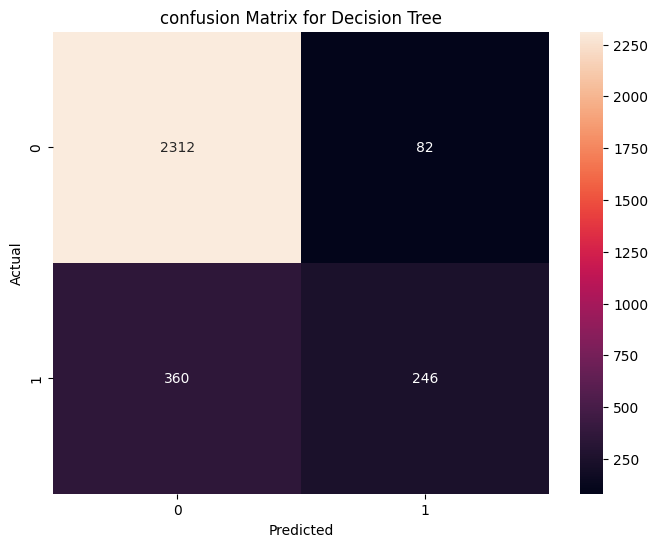

In [31]:
# cell 30
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('confusion Matrix for Decision Tree')
plt.show()

Result : The True Positive shows the count of correctly classified data points whereas the False Positive elements are those that are misclassified by the model. The higher the True Positive values of the confusion matrix the better, indicating many correct predictions.

Accuracy Score :

In [32]:
# cell 31
accuracy_score(y_test, y_pred)

0.8526666666666667

##### Using RandomForest

In [33]:
# cell 32
rfc = RandomForestClassifier()

param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2,4,6,8,10], 
              'min_samples_leaf': [2,4,6,8,10],
              'random_state': [0, 42]}

grid_rfc = GridSearchCV(rfc, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

grid_rfc.fit(X_train, y_train)

print(grid_rfc.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'random_state': 42}


In [34]:
# cell 33
rf_model = RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4, random_state=42)

rf_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4,
                       random_state=42)

In [35]:
# cell 34
y_pred_rf = rf_model.predict(X_test)

evaluation : 

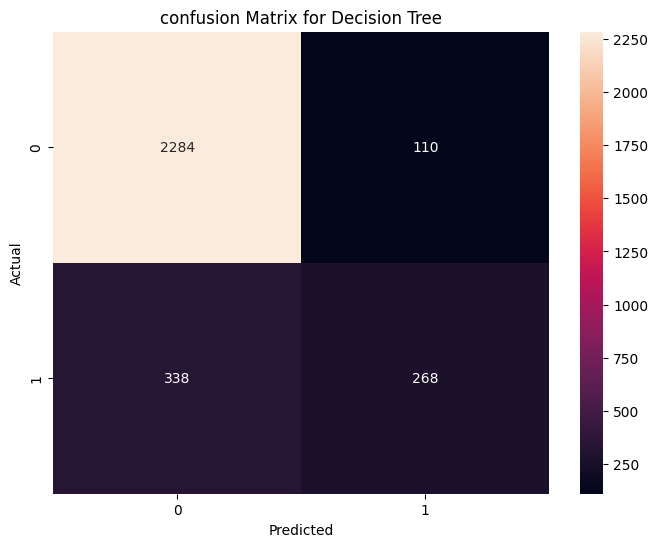

In [36]:
# cell 35
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('confusion Matrix for Decision Tree')
plt.show()

Accuracy Score : 

In [37]:
# cell 36
accuracy_score(y_test, y_pred_rf)

0.8506666666666667

Conclusion : From the beginning, our goal was to use the knowledge we have to design a model that predicts with the maximum possible accuracy whether a customer with certain features will leave the bank or not.
If it is due to leaving the bank, it is necessary to think of necessary measures.